# Pose Estimation

In this notebook, we will create a yoga pose classifier. This take an input image and find the best match from the available yoga pose information we have. The classifier will extact the images key-point's and compare these to the labeled training dataset we have to identify the best match.

Current available yoga poses:
- Crescent Lunge
- Downward Dog
- Extended Triangle
- Warrior

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import warnings
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir
from os.path import join

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import mediapipe as mp

In [3]:
# Media Pipe Constants
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

POSE_LANDMARKS = [m.name for m in mp_pose.PoseLandmark]
index_to_body_mapping = {i:body_part.lower() for i, body_part in enumerate(POSE_LANDMARKS)}

vertex_angle_constants = ["Left_armpit_angle", "Right_armpit_angle", "Left_shoulder_angle", "Right_shoulder_angle", "Left_elbow_angle", "Right_elbow_angle", 
                           "Left_hip_angle", "Right_hip_angle", "Left_groin_angle", "Right_groin_angle", "Left_knee_angle", "Right_knee_angle"]

In [4]:
index_to_body_mapping

{0: 'nose',
 1: 'left_eye_inner',
 2: 'left_eye',
 3: 'left_eye_outer',
 4: 'right_eye_inner',
 5: 'right_eye',
 6: 'right_eye_outer',
 7: 'left_ear',
 8: 'right_ear',
 9: 'mouth_left',
 10: 'mouth_right',
 11: 'left_shoulder',
 12: 'right_shoulder',
 13: 'left_elbow',
 14: 'right_elbow',
 15: 'left_wrist',
 16: 'right_wrist',
 17: 'left_pinky',
 18: 'right_pinky',
 19: 'left_index',
 20: 'right_index',
 21: 'left_thumb',
 22: 'right_thumb',
 23: 'left_hip',
 24: 'right_hip',
 25: 'left_knee',
 26: 'right_knee',
 27: 'left_ankle',
 28: 'right_ankle',
 29: 'left_heel',
 30: 'right_heel',
 31: 'left_foot_index',
 32: 'right_foot_index'}

In [5]:
def _normalize_color(color):
     return tuple(v / 255. for v in color)

def get_valid_pose_folder_names(folder_dir, must_start_with_pose=True):
    subfolders = os.listdir(folder_dir) 

    # Get valid folders
    valid_folders = []
    for subfolder in subfolders:
        bool_clause = must_start_with_pose = subfolder.startswith("pose")
        if bool_clause and os.path.isdir(os.path.join(folder_dir, subfolder)):
            valid_folders.append(subfolder)

    return valid_folders


def generate_pose_landmarks(input_img, min_detection_confidence=0.75, model_complexity=2):
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=min_detection_confidence, model_complexity=model_complexity, 
    ) as pose:
        input_results = pose.process(input_img)

        landmark_body_arr = []
        for i, landmark in enumerate(input_results.pose_world_landmarks.landmark):
            body_part = index_to_body_mapping[i]
            landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

        columns = ["pose_landmark", "x", "y", "z", "visibility"]
        input_landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
        
    return input_landmark_pose_df


def read_and_display_image(img_path, true_pose):
    input_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
    plt.title(f"True Pose: {true_pose}", fontsize=18)
    plt.imshow(input_img)
    plt.show()
    
    return input_img


def flip_image_horizontally(img_rgb):
    image = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    flip_image = cv2.flip(image, 1)
    
    flip_rgb_image = cv2.cvtColor(flip_image, cv2.COLOR_BGR2RGB)
    return flip_rgb_image


def custom_plot_landmarks_from_df(
    landmark_df,
    ax=None,
    add_connections: bool = True,
    landmark_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.RED_COLOR, thickness=5),
    connection_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.BLACK_COLOR, thickness=5),
    visibility_threshold=0.5,
    presence_threshold=0.5,
):
    """Plot the landmarks and the connections in matplotlib 3d.
    Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.
    Raises:
    ValueError: If any connetions contain invalid landmark index.
    """
    if landmark_df is None:
        return
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=10, azim=10)
    
    plotted_landmarks = {}
    for i_row, landmark_dict in landmark_df.iterrows():
        if (('visibility' in landmark_dict) and (landmark_dict["visibility"] < visibility_threshold)) or \
        (('presence' in landmark_dict) and (landmark_dict['presence'] < presence_threshold)):
            continue
            
        ax.scatter3D(
            xs=[-landmark_dict['z']],
            ys=[landmark_dict['x']],
            zs=[-landmark_dict['y']],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness
        )
        plotted_landmarks[i_row] = (-landmark_dict['z'], landmark_dict['x'], -landmark_dict['y'])
        
    if add_connections:
        num_landmarks = landmark_df.shape[0]
        
        # Draws the connections if the start and end landmarks are both visible.
        connections = mp_pose.POSE_CONNECTIONS
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness
                )

    return ax

In [6]:
def get_bodypart_angle_df(landmarks_df):
    # lowercase all poses
    landmarks_df['pose_landmark'] = landmarks_df['pose_landmark'].str.lower() 
    
    # Populate for each 
    angles_dict = get_vertex_angles_dict(landmarks_df)
    df = pd.DataFrame(columns=vertex_angle_constants)   
    df = df.append(angles_dict, ignore_index=True)
    
    return df       


# Check calc_angle_between_three_2d_points([1,1], [2, 2], [3, 1]) == 90 - Good :)
def calc_angle_between_three_2d_points(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def estimate_line_vertex_angles(landmarks_df, pos_1, vertex_pos, pos_3):
    p1 = landmarks_df[landmarks_df["pose_landmark"] == pos_1].iloc[0][["x", "y", "z"]].values.tolist()
    p2 = landmarks_df[landmarks_df["pose_landmark"] == vertex_pos].iloc[0][["x", "y", "z"]].values.tolist()
    p3 = landmarks_df[landmarks_df["pose_landmark"] == pos_3].iloc[0][["x", "y", "z"]].values.tolist()
    
    angle_degrees = calc_angle_between_three_2d_points(p1, p2, p3)
    assert angle_degrees <= 360
    
    return angle_degrees
    
    
def get_vertex_angles_dict(landmarks_df):
    angles_dict = {}
    
    angles_dict["Left_armpit_angle"] = estimate_line_vertex_angles(landmarks_df, "left_shoulder", "left_elbow", "left_hip")
    angles_dict["Right_armpit_angle"] = estimate_line_vertex_angles(landmarks_df, "right_shoulder", "right_elbow", "right_hip")
    angles_dict["Left_shoulder_angle"] = estimate_line_vertex_angles(landmarks_df, "left_shoulder", "right_shoulder", "left_hip")
    angles_dict["Right_shoulder_angle"] = estimate_line_vertex_angles(landmarks_df, "right_shoulder", "left_shoulder", "right_hip")
    angles_dict["Left_elbow_angle"] = estimate_line_vertex_angles(landmarks_df, "left_elbow", "left_shoulder", "left_wrist")
    angles_dict["Right_elbow_angle"] = estimate_line_vertex_angles(landmarks_df, "right_elbow", "right_shoulder", "right_wrist")
    angles_dict["Left_hip_angle"] = estimate_line_vertex_angles(landmarks_df, "left_hip", "right_hip", "left_shoulder")
    angles_dict["Right_hip_angle"] = estimate_line_vertex_angles(landmarks_df, "right_hip", "left_hip", "right_shoulder")
    angles_dict["Left_groin_angle"] = estimate_line_vertex_angles(landmarks_df, "left_hip", "left_knee", "left_ankle")
    angles_dict["Right_groin_angle"] = estimate_line_vertex_angles(landmarks_df, "right_hip", "right_knee", "right_ankle")
    angles_dict["Left_knee_angle"] = estimate_line_vertex_angles(landmarks_df, "left_knee", "left_ankle", "left_hip")
    angles_dict["Right_knee_angle"] = estimate_line_vertex_angles(landmarks_df, "right_knee", "right_ankle", "right_hip")
    
    return angles_dict

def plot_2d_pca_figure(df: pd.DataFrame, point_to_add: np.array = None):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 

    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('PCA of Positions', fontsize = 20)

    poses = df["pose_type"].unique().tolist()
    colors = ['r','g', 'b', 'y', 'm', 'c']

    for pose, color in zip(poses, colors):            
        idx_to_display = df['pose_type'] == pose
        ax.scatter(
            df.loc[idx_to_display, 'principal component 1'],
            df.loc[idx_to_display, 'principal component 2'],
            c = color, 
            alpha = 0.7
        )
        
    if point_to_add is not None:
        ax.scatter(
            point_to_add[0],
            point_to_add[1],
            c = "k", 
            alpha = 1.0,
            marker="X",
            s=150,
        )
        ax.legend(poses + ["Unlabeled Pose"], loc='upper left')
    else:
        ax.legend(poses, loc='upper left')

        
    ax.grid()
    plt.show()
    
    return ax


def fit_knn_classifier(df, taget_col_name="pose_type", n_neighbors=3):

    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)    
    knn_classifier.fit(df.drop(columns=taget_col_name), df[taget_col_name])
    
    return knn_classifier


def estimate_bodypart_angle_alignment(image, true_pose, plot_3d_img=True):
    landmarks_df = generate_pose_landmarks(image)

    if plot_3d_img:
        # Plot the 3D constuction
        custom_plot_landmarks_from_df(landmarks_df)
                
    return
    

## Training Data setup

In [7]:
folder_dir = "inputs/yoga_poses/"
csv_folder_dir = os.path.join(folder_dir, "pose_classification.csv")

create_new_pose_classification_df = False

if create_new_pose_classification_df:
    pose_classification_df = create_pose_classification_df(folder_dir)
    pose_classification_df.to_csv(csv_folder_dir, index=False)
else:
    pose_classification_df = pd.read_csv(csv_folder_dir)

pose_classification_df.head()

,image_path,pose_type
0,inputs/yoga_poses/pose_crescent_lunge/3.jpg,crescent_lunge
1,inputs/yoga_poses/pose_crescent_lunge/1.jpg,crescent_lunge
2,inputs/yoga_poses/pose_crescent_lunge/2.jpg,crescent_lunge
3,inputs/yoga_poses/pose_camel/3.jpg,camel
4,inputs/yoga_poses/pose_camel/1.jpeg,camel


#### Run if we want to add new yoga pose data to the training set

In [8]:
create_new_csvs= False

if create_new_csvs:
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:
        for i_row, df in pose_classification_df.iterrows():
            image_path = df["image_path"]        
            pose_dir = os.path.dirname(image_path)
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            results = pose.process(image)

            landmark_body_arr = []
            for i, landmark in enumerate(results.pose_world_landmarks.landmark):
                body_part = index_to_body_mapping[i]
                landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

            columns = ["pose_landmark", "x", "y", "z", "visibility"]
            landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
            landmark_pose_df.to_csv(os.path.join(pose_dir, f"{base_name}_landmarks_holistic_0-75_2.csv"), index=False)    


## KNN pose classification

In [9]:
# Load in DF of all yoga images
folder_dir = "inputs/yoga_poses/"
csv_folder_dir = os.path.join(folder_dir, "pose_classification.csv")
pose_classification_df = pd.read_csv(csv_folder_dir)

# Get All pose names
base_pose_dir = "inputs/yoga_poses/"
available_pose_names = get_valid_pose_folder_names(folder_dir)
available_pose_names

['pose_crescent_lunge',
 'pose_warrior',
 'pose_extended_triangle',
 'pose_downwards_dog']

In [10]:
# Turn warnings off
warnings.filterwarnings("ignore", category=FutureWarning)

all_pose_frames = []

for pose_name in available_pose_names:
    single_pose_folder = os.path.join(base_pose_dir, pose_name)
    single_pose_files = os.listdir(single_pose_folder)

    for file in single_pose_files:
        if not ".csv" in file:
            continue

        curr_landmarks_df = pd.read_csv(os.path.join(single_pose_folder, file))        
        angles_df = get_bodypart_angle_df(curr_landmarks_df)
        angles_df["pose_type"] = pose_name
        all_pose_frames.append(angles_df)
        

# Turn warnings back on
warnings.filterwarnings("default", category=FutureWarning)

# Append all rows
all_poses_df = pd.concat(all_pose_frames).reset_index(drop=True)
print(f"all_poses_df: {all_poses_df.shape}")
all_poses_df.head()

all_poses_df: (14, 13)


,Left_armpit_angle,Right_armpit_angle,Left_shoulder_angle,Right_shoulder_angle,Left_elbow_angle,Right_elbow_angle,Left_hip_angle,Right_hip_angle,Left_groin_angle,Right_groin_angle,Left_knee_angle,Right_knee_angle,pose_type
0,12.541643,31.524616,59.995025,79.211543,12.448444,31.330298,70.083624,69.074423,112.391802,147.00458,31.67801,14.227233,pose_crescent_lunge
1,11.888171,30.424295,56.948161,76.784975,12.181707,31.227774,68.149518,65.574851,118.629668,148.329243,28.354241,14.032672,pose_crescent_lunge
2,4.068433,6.20493,59.305609,71.45006,17.541802,13.544875,60.515999,73.107563,153.133218,110.072427,13.077177,28.743207,pose_crescent_lunge
3,55.508006,78.223897,60.639146,64.600228,3.315841,13.812747,64.488344,61.796008,159.078252,109.136184,10.377522,28.954885,pose_warrior
4,57.265116,76.695563,55.267135,71.959579,3.513063,11.374307,61.743981,66.082676,93.786843,139.22874,40.376717,15.047133,pose_warrior


### Fit a PCA object followed by a KNN

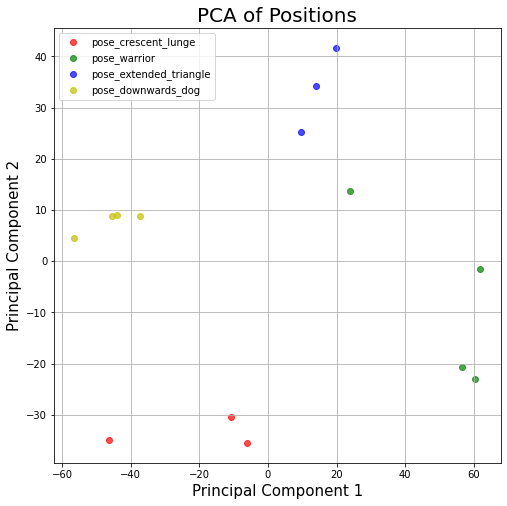

,principal component 1,principal component 2,pose_type
0,-6.111694,-35.530695,pose_crescent_lunge
1,-10.791353,-30.380811,pose_crescent_lunge
2,-46.160407,-35.025082,pose_crescent_lunge
3,24.042918,13.749582,pose_warrior
4,60.353571,-22.933535,pose_warrior


In [11]:
# Create training PCA data frame
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(all_poses_df.drop(columns="pose_type"))
pca_pose_df = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])
pca_pose_df = pd.concat([pca_pose_df, all_poses_df[["pose_type"]]], axis = 1)

plot_2d_pca_figure(pca_pose_df)
pca_pose_df.head()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


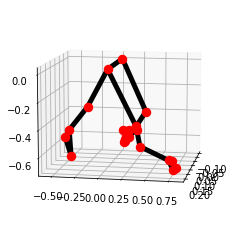

/tmp/ipykernel_22563/4176259266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


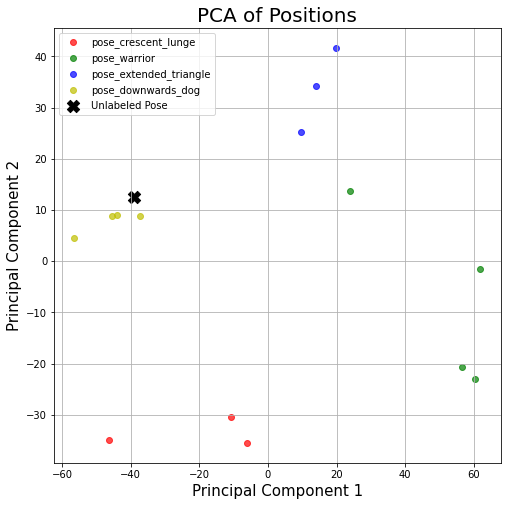

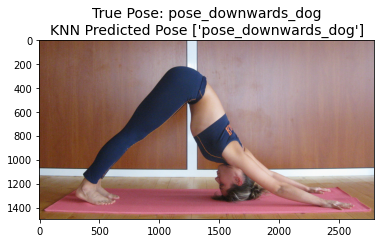

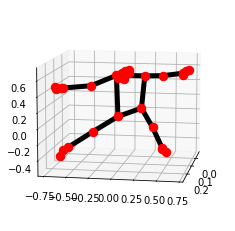

/tmp/ipykernel_22563/4176259266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


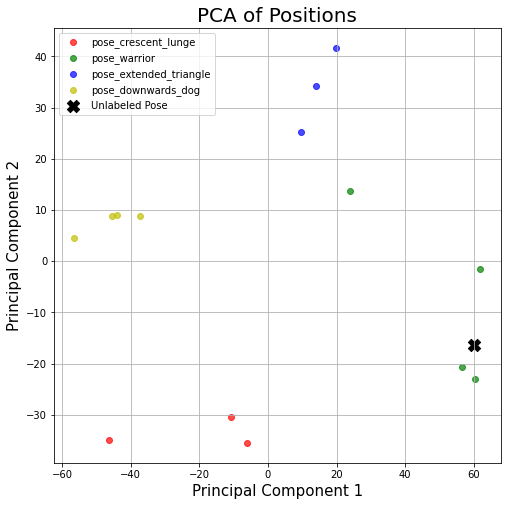

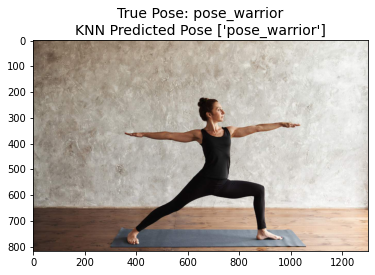

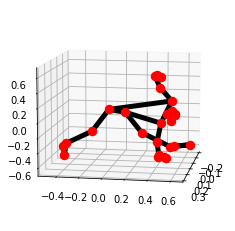

/tmp/ipykernel_22563/4176259266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


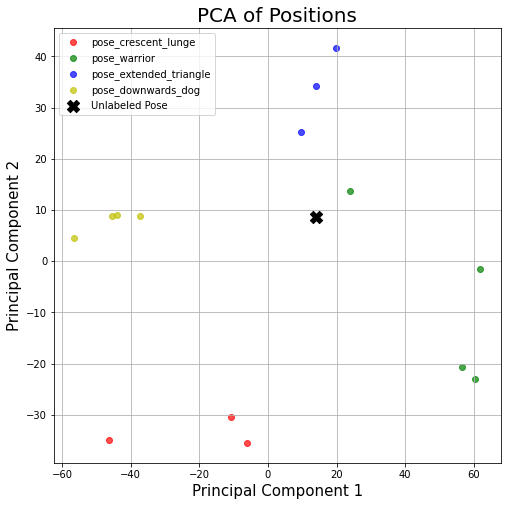

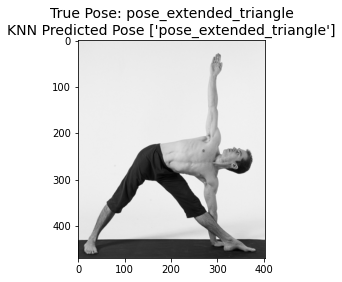

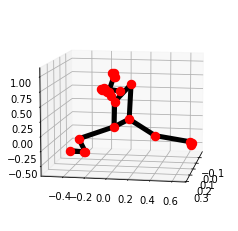

/tmp/ipykernel_22563/4176259266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


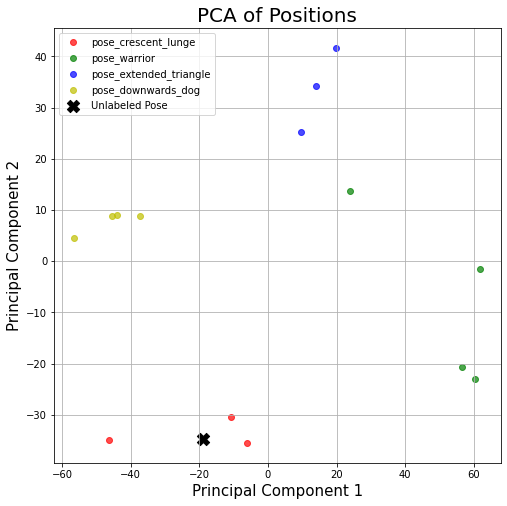

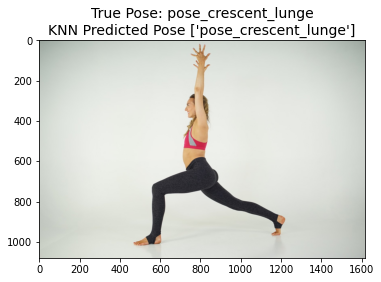

In [12]:
# Fit knn classifier
knn_classifier = fit_knn_classifier(df=pca_pose_df)


# Iterate through Test batch now
base_pose_dir = "inputs/yoga_poses/"
available_pose_names = get_valid_pose_folder_names(folder_dir)

input_imgs = ["downward_facing_dog.JPG", "warrior.jpg", "extended_triangle.png", "crescent_lunge.jpg"]
input_img_paths = [os.path.join("inputs/yoga_poses/test_poses/", f) for f in input_imgs]

true_poses = ["pose_downwards_dog", "pose_warrior", "pose_extended_triangle", "pose_crescent_lunge"]


for input_image_path, true_pose in zip(input_img_paths, true_poses):
    # Read in image
    input_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
    
    # Get landmarks df
    landmarks_df = generate_pose_landmarks(input_img)
    
    # Plot generated landmarks
    custom_plot_landmarks_from_df(landmarks_df)
    plt.show()
    
    # Predict Label
    pca_landmarks_df = pca.transform(get_bodypart_angle_df(landmarks_df))
    predicted_pca_knn_label = knn_classifier.predict(pca_landmarks_df)
    
    # Plot PCA yoga pose seperation with new transformed point
    ax = plot_2d_pca_figure(pca_pose_df, point_to_add=(pca_landmarks_df.flatten()))
    
    # Plot actual image and predicted vs true pose
    fig, ax = plt.subplots()
    title = f"True Pose: {true_pose}\nKNN Predicted Pose {predicted_pca_knn_label}"
    plt.title(title, fontsize=14)
    plt.imshow(input_img)
    plt.show()

# Results

The classifer has 100% accuracy. In each instance we get a clearly distiguistable point on the PCA plot.

## Improvements
- Add more yoga poses to the training dataset